In [12]:
import datasets
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from datasets import load_dataset
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

In [13]:
dataset = load_dataset("ag_news")

In [14]:
def get_balanced_dataset(dataset, percentage):
    import warnings
    warnings.filterwarnings("ignore", category=DeprecationWarning) 
    dataset = pd.DataFrame(dataset)
    dataset = dataset[['text', 'label']]
    dataset = dataset.groupby("label").apply(lambda x: x.sample(frac=percentage)).reset_index(drop=True)
    return dataset

In [15]:
Categories = ["World", "Sports", "Business", "Sci/Tech"]
Categories

['World', 'Sports', 'Business', 'Sci/Tech']

In [16]:
perc_train = 0.14
perc = 0.25

train_df = get_balanced_dataset(dataset["train"], perc_train)
teste_df = get_balanced_dataset(dataset["test"], perc)

# Contagem de labels em cada dataset
count_train = train_df['label'].value_counts()
count_test = teste_df['label'].value_counts()

# Encontrando a menor contagem em cada dataset
min_count_train = count_train.min()
min_count_test = count_test.min()

# Fazendo o resample (downsampling) para o dataset de treino
train_df = pd.concat([
    train_df[train_df['label'] == label].sample(n=min_count_train, random_state=42)
    for label in train_df['label'].unique()
])

# Fazendo o resample (downsampling) para o dataset de teste
teste_df = pd.concat([
    teste_df[teste_df['label'] == label].sample(n=min_count_test, random_state=42)
    for label in teste_df['label'].unique()
])

# training_set = list(zip(train_df["text"], train_df["label"]))
# test_set = list(zip(teste_df["text"], teste_df["label"]))

In [17]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_train = tfidf_vectorizer.fit_transform(train_df["text"].to_list())
tfidf_test = tfidf_vectorizer.transform(teste_df["text"].to_list())

train_df['text_tfdif'] = list(tfidf_train.toarray())
teste_df['text_tfdif'] = list(tfidf_test.toarray())

In [18]:
train_df

,text,label,text_tfdif
1743,Venezuelan president votes at regional electio...,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2196,Carson man charged with Iraqi #39;s murder Two...,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1728,Manila's Cardinal Sin Rushed to Hospital MANI...,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3337,Controversial Swiss culture show abroad sparks...,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
298,Tampa Newspaper Withholds Endorsement (AP) AP ...,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...
16044,ISPs File Suits Against Spammers (washingtonpo...,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
13066,AT amp;T and IXI launch OGO IXI Mobile and AT ...,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
15692,"SBC, Yahoo, 2Wire, and Dish Network Partner Fo...",3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
16372,New IBM Systems Mark Storage/Server Convergenc...,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [19]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

model.fit(list(train_df["text_tfdif"]), train_df["label"])

LogisticRegression()

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

y_hat = model.predict(list(teste_df["text_tfdif"]))
y_test = teste_df["label"].to_list()

In [21]:
#compute accuracy
accuracy = sum([y_hat[i] == y_test[i] for i in range(len(y_test))]) / len(y_test)
print(f"Accuracy: {accuracy}")

#compute recall
recall = recall_score(y_test, y_hat, average='macro')
print(f"Recall: {recall}")

#compute precision
precision = precision_score(y_test, y_hat, average='macro')
print(f"Precision: {precision}")

#compute f1 score
f1 = f1_score(y_test, y_hat, average='macro')
print(f"F1 Score: {f1}")

Accuracy: 0.8794736842105263
Recall: 0.8794736842105263
Precision: 0.8795591913649224
F1 Score: 0.8789053233115879


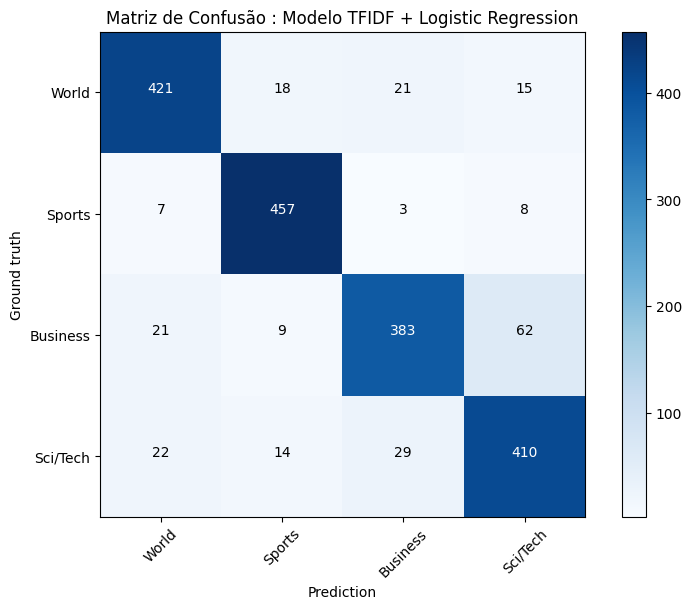

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

conf_matrix = confusion_matrix(y_test, y_hat)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusão : Modelo TFIDF + Logistic Regression')
plt.colorbar()


tick_marks = np.arange(len(Categories))
plt.xticks(tick_marks, Categories, rotation=45)
plt.yticks(tick_marks, Categories)


thresh = conf_matrix.max() / 2.
for i, j in [(i, j) for i in range(conf_matrix.shape[0]) for j in range(conf_matrix.shape[1])]:
    plt.text(j, i, conf_matrix[i, j], horizontalalignment="center", color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('Ground truth')
plt.xlabel('Prediction')
plt.show()